In [1]:
import os
import librosa
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa.display
import tqdm
import ast

import plotly.graph_objects as go
import plotly.express as px

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots

from get_mel_spectrogram import get_mel_spectrogram

In [2]:
# get the parent directory
parent_dir = os.path.abspath('..')
test_dir = os.path.join(parent_dir, 'Testing', 'dataSubsets')
data_dir = os.path.join(parent_dir, 'Data')
meta_dir = os.path.join(data_dir, 'metadata')
sour_dir = os.path.join(data_dir, 'source')
data_dir = os.path.join(parent_dir, 'EDA')

In [3]:
metadata = pd.read_csv(os.path.join(meta_dir, 'metadata_w_features.csv'), index_col=0, dtype=object)

In [4]:
# because I stored the numpy arrays in pandas quite carelessly I have to format them out 
# to read them as the lists they actually are.

In [5]:
features = metadata['mfcc']

In [6]:
def convertFromCSV(feature):
    
    feature = feature.replace(' ', ', ')
    feature = feature.replace('\n', '')
    feature = feature.replace(', , , ', ', ')
    feature = feature.replace(', , ', ', ')
    feature = feature.replace('[,','[')
    feature = feature.replace(']]',']')
    feature = feature.replace(', ]',']')
    feature = feature.replace(', , ',', ')
    feature = feature.strip()                                                                                                                        
                                                                                                                                   
    the_list = ''
    feature_formatted = []

    for letter in feature:
        if letter == '[':
            the_list = ''
            the_list += letter
        elif letter == ']':
            the_list += letter
            feature_formatted.append( np.array(ast.literal_eval(the_list)).ravel() )
        else:
            the_list += letter

    return feature_formatted

In [7]:
new_features = []

for x in tqdm.tqdm(features):
    feature_formatted = convertFromCSV(x)
    new_features.append(feature_formatted)

100%|██████████| 18019/18019 [01:38<00:00, 182.34it/s]


In [8]:
for idx, feature in enumerate(new_features):
    new_features[idx] = (np.asarray(feature)).ravel()

In [9]:
mel_spect_db = metadata['mel_spect_db']

In [ ]:
new_mel_spect_db = []

for x in tqdm.tqdm(mel_spect_db):
    mel_spect_db_formatted = convertFromCSV(x)
    new_mel_spect_db.append(mel_spect_db_formatted)

  4%|▍         | 718/18019 [00:03<01:19, 216.83it/s]

In [ ]:
for idx, feature in enumerate(new_mel_spect_db):
    new_mel_spect_db[idx] = (np.asarray(feature)).ravel()

In [ ]:
metadata['mfcc'] = new_features
metadata['mel_spect_db'] = new_mel_spect_db

In [ ]:
fans = metadata.loc[metadata['machine'] == 'fan']

In [14]:
X_train, X_test, _, _ = train_test_split(fans['mfcc'].to_list(), fans['mfcc'].to_list(), test_size = 0.2, random_state = 2)

In [15]:
scores = []
means = []
for k in tqdm.tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(fans['mfcc'].to_list())
    means.append(kmeans)
    scores.append(kmeans.score(fans['mfcc'].to_list()))
    # Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


Text(0.5, 1.0, 'Elbow curve')

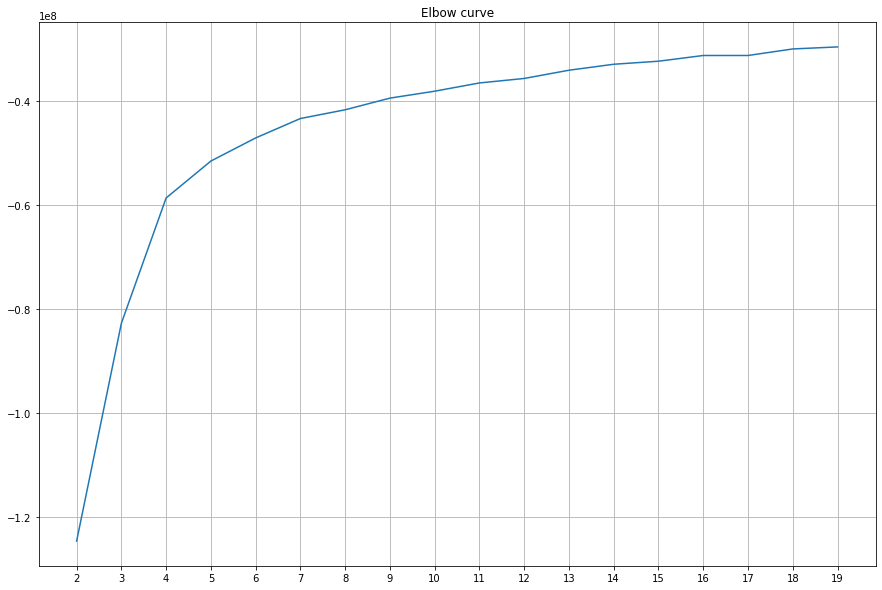

In [16]:
fig = plt.figure(figsize=(15, 10))
plt.plot(range(2, 20), scores)
plt.xticks(np.arange(2, 20, 1.0))
plt.grid(True)
plt.title('Elbow curve')

In [17]:
scores = np.array(scores)
dif_scores = scores/scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)

15


In [49]:
# Use what would be known as the optimale amount of clusters.
kmeans = KMeans(n_clusters=15)

# fit the KMeans algorithm to the fan samples
kmeans.fit(fans['mfcc'].to_list())

# clusters is the mean of each feature we have that defines a cluster.
cluster_centers = kmeans.cluster_centers_

# cluster labels are the predictions our fitted KMeans algortihm gives.
cluster_labels = pd.Series(kmeans.labels_, name='cluster')

In [51]:
fig = px.histogram(
    color=fans["anomaly"], 
    x=cluster_labels, 
    opacity = 0.8, 
    color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(
    title_text="anomaly distribution accuracy per cluster - Fan",
    xaxis_title="Cluster",
    yaxis_title="Count",
    legend_title="Anomaly",
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))

fig.show()

# Using the supposedly optimal number of clusters We get this distribution.
# clusters 4, 8 and 13 seem almost entirely normal.
# The distribution of the abnormal samples is spaced out, but there are some entirely different ones there.

In [52]:
fig = px.histogram(
    color=fans["model"], 
    x=cluster_labels, 
    opacity = 0.8, 
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    title_text="model distribution accuracy per cluster - Fan",
    xaxis_title="Cluster",
    yaxis_title="Count",
    legend_title="Model",
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))

fig.show()

# this graph makes more sense, I think. Most of the clusters seem to exclusively take only one
# model type. I conclude that at least for the fan machine type I need to cluster by model as well.

In [53]:
fig = px.histogram(
    color=fans["model"], 
    x=cluster_labels, 
    pattern_shape=fans['anomaly'], 
    opacity = 0.8,
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    title_text="model distribution accuracy per cluster with anomaly - Fan",
    xaxis_title="Cluster",
    yaxis_title="Count",
    legend_title="Model - Anomaly",
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))


fig.show()

# When I add the anomalies in there it again shows little correlation.
# 

In [22]:
fans['cluster'] = cluster_labels

for cluster in range(15):
    selected = fans.loc[fans["cluster"] == cluster]
    print(f"for cluster {cluster}\n")
    
    total = sum(selected['model'].value_counts().to_list())
    high = max(selected['model'].value_counts().to_list())
    
    predicted_model = selected['model'].value_counts().index[0]
    
    print(f"prediction is model type {predicted_model} with {round(high/total, 2) *100}% accuracy")
    ratio_per_model = selected['model'].value_counts()

for cluster 0

prediction is model type 2 with 100.0% accuracy
for cluster 1

prediction is model type 2 with 99.0% accuracy
for cluster 2

prediction is model type 4 with 99.0% accuracy
for cluster 3

prediction is model type 6 with 100.0% accuracy
for cluster 4

prediction is model type 0 with 91.0% accuracy
for cluster 5

prediction is model type 6 with 100.0% accuracy
for cluster 6

prediction is model type 0 with 91.0% accuracy
for cluster 7

prediction is model type 6 with 100.0% accuracy
for cluster 8

prediction is model type 0 with 91.0% accuracy
for cluster 9

prediction is model type 4 with 100.0% accuracy
for cluster 10

prediction is model type 0 with 92.0% accuracy
for cluster 11

prediction is model type 6 with 99.0% accuracy
for cluster 12

prediction is model type 4 with 100.0% accuracy
for cluster 13

prediction is model type 0 with 100.0% accuracy
for cluster 14

prediction is model type 0 with 93.0% accuracy


C:\Users\aubin\AppData\Local\Temp/ipykernel_17084/443814590.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# how to get clusters representing the target for each model type individually

In [24]:
model_1 = fans.loc[fans['model'] == '0']
model_2 = fans.loc[fans['model'] == '2']
model_3 = fans.loc[fans['model'] == '4']
model_4 = fans.loc[fans['model'] == '6']
models = [model_1, model_2, model_3, model_4]

In [25]:
model_1.shape

(1418, 14)

In [26]:
scores = []
means = []
for k in tqdm.tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(model_1['mfcc'].to_list())
    means.append(kmeans)
    scores.append(kmeans.score(model_1['mfcc'].to_list()))
    # Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

100%|██████████| 18/18 [00:06<00:00,  2.77it/s]


Text(0.5, 1.0, 'Elbow curve')

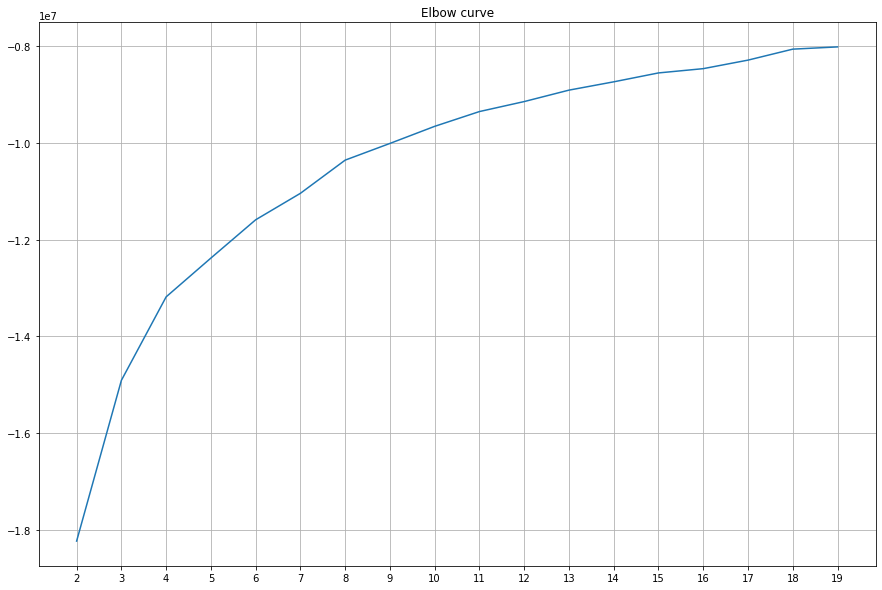

In [27]:
fig = plt.figure(figsize=(15, 10))
plt.plot(range(2, 20), scores)
plt.xticks(np.arange(2, 20, 1.0))
plt.grid(True)
plt.title('Elbow curve')

In [28]:
scores = np.array(scores)
dif_scores = scores/scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)
# as the model doesn't come very close to the 0 point on the y-axis, I would conclude that the mfcc 
# doesn't represent anomalies very well.
# The optimal number of clusters here is again 16, even though the models have already been seperated

15


In [29]:
# Use what would be known as the optimale amount of clusters.
kmeans = KMeans(n_clusters=2)

# fit the KMeans algorithm to the fan samples
kmeans.fit(model_1['mfcc'].to_list())

# clusters is the mean of each feature we have that defines a cluster.
cluster_centers = kmeans.cluster_centers_

# cluster labels are the predictions our fitted KMeans algortihm gives.
cluster_labels = pd.Series(kmeans.labels_, name='cluster')

In [30]:
fig = px.histogram(
    color=model_1["anomaly"], 
    x=cluster_labels, 
    opacity = 0.8, 
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.show()

# The distribution between the anomaly/normal makes little sense, so I conclude mfcc is bad for 
# this type of clustering.

In [31]:
# As it turns out, that was a load of shit, mfcc and mel_spect give different results, but the reason 
# I couldn't find the correct clusters is because of difference between model types as I was only testing
# model 1.

In [32]:
scores = [[],[],[],[]]
means = [[],[],[],[]]

for idx, model_frame in enumerate(models):
    for k in tqdm.tqdm(range(2, 20)):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(model_frame['mel_spect_db'].to_list())
        means[idx].append(kmeans)
        scores[idx].append(kmeans.score(model_frame['mel_spect_db'].to_list()))
        # Sum of squared distances of samples to their closest cluster center, 
        # weighted by the sample weights if provided.

100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


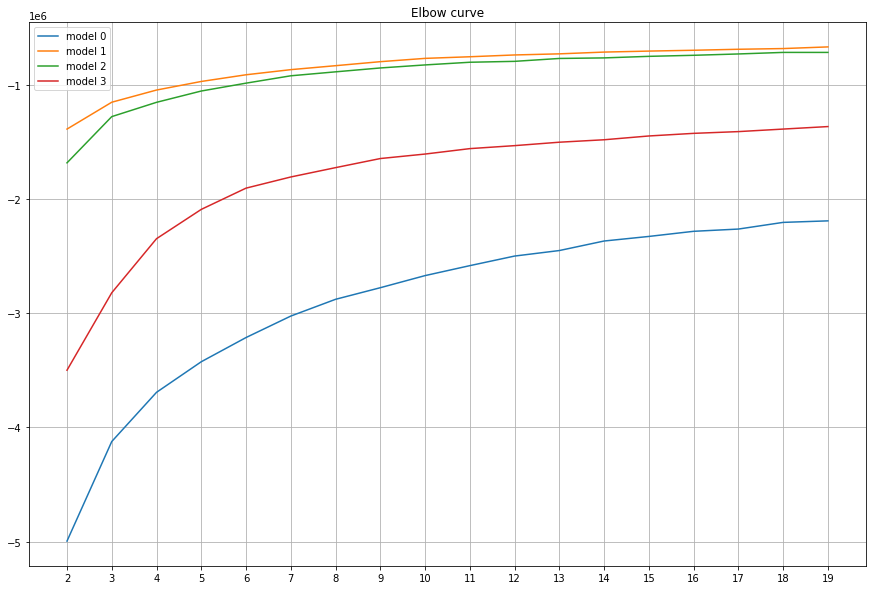

In [33]:
fig = plt.figure(figsize=(15, 10))

for x in range(4):
    plt.plot(range(2, 20), scores[x], label = f"model {x}")

plt.legend(loc="upper left")
plt.xticks(np.arange(2, 20, 1.0))
plt.grid(True)
plt.title('Elbow curve')

fig.savefig('elbow Curve - mel_spect - Fans.png') 

# there is a very big difference between the results per model type

In [34]:
# You can tell that for model 1 and 2 prediction is feasible using this type of clustering. The other 2 
# are significantly less usefull for prediction.

# Below I plotted the results of using mfcc in stead of the mel_spect features

100%|██████████| 18/18 [00:05<00:00,  3.18it/s]


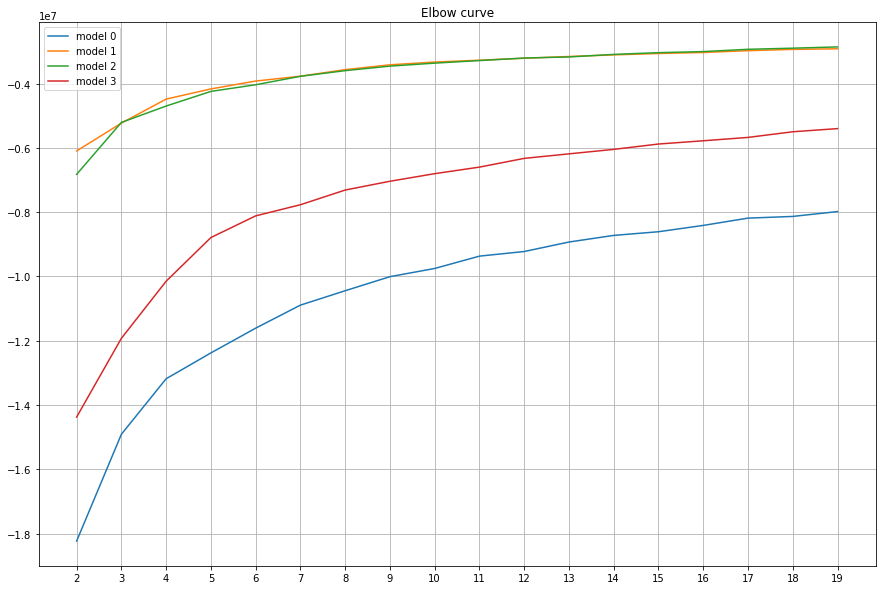

In [35]:
scores = [[],[],[],[]]
means = [[],[],[],[]]

for idx, model_frame in enumerate(models):
    for k in tqdm.tqdm(range(2, 20)):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(model_frame['mfcc'].to_list())
        means[idx].append(kmeans)
        scores[idx].append(kmeans.score(model_frame['mfcc'].to_list()))
        # Sum of squared distances of samples to their closest cluster center, 
        # weighted by the sample weights if provided.
        
fig = plt.figure(figsize=(15, 10))

for x in range(4):
    plt.plot(range(2, 20), scores[x], label = f"model {x}")

plt.legend(loc="upper left")
plt.xticks(np.arange(2, 20, 1.0))
plt.grid(True)
plt.title('Elbow curve')

fig.savefig('elbow Curve - mfcc - Fans.png') 

In [36]:
for idx, score in enumerate(scores):
    score = np.array(score)
    dif_scores = score/score[0]
    dif_scores = np.diff(dif_scores)
    n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
    print(f"for model : {idx} best amount of clusters is : {n_clusters}")

for model : 0 best amount of clusters is : 16
for model : 1 best amount of clusters is : 15
for model : 2 best amount of clusters is : 16
for model : 3 best amount of clusters is : 15


In [37]:
# I believe the formula above may be shit, it makes more sense like this :

In [38]:
for idx, score in enumerate(scores):
    score = np.array(score)
    dif_scores = score/score[0]
    dif_scores = np.diff(dif_scores)
    n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.2))[-1][0]
    print(f"for model : {idx} best amount of clusters is : {n_clusters}")

for model : 0 best amount of clusters is : 3
for model : 1 best amount of clusters is : 3
for model : 2 best amount of clusters is : 4
for model : 3 best amount of clusters is : 3


In [39]:
scores = np.array(scores)
dif_scores = scores/scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)
# as the model doesn't come very close to the 0 point on the y-axis, I would conclude that the mfcc 
# doesn't represent anomalies very well.
# The optimal number of clusters here is again 16, even though the models have already been seperated

3


In [55]:
kmeans_results = [[],[],[],[]]
cluster_centers = [[],[],[],[]]
cluster_labels = [[],[],[],[]]

for idx, model in enumerate(models):

    # Use what would be known as the optimale amount of clusters.
    kmeans = KMeans(n_clusters=3)

    # fit the KMeans algorithm to the fan samples
    kmeans_results[idx] = kmeans.fit(model['mfcc'].to_list())

    # clusters is the mean of each feature we have that defines a cluster.
    cluster_centers[idx] = kmeans.cluster_centers_

    # cluster labels are the predictions our fitted KMeans algortihm gives.
    cluster_labels[idx] = pd.Series(kmeans.labels_, name='cluster')

In [56]:
fig = make_subplots(rows=2, cols=2)
traces = [[],[],[],[]]

for x in range(4):
    
    traces[x] = px.histogram(
        color=models[x]['anomaly'], 
        x=cluster_labels[x], 
        opacity = 0.8, 
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    
fig.update_layout(
    title_text="KMeans anomaly distribution per model - Fan",
    xaxis_title="Cluster",
    yaxis_title="Count",
    legend_title="Anomaly",
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))

    
fig.add_traces(list(traces[0].select_traces()), 1, 1)
fig.add_traces(list(traces[1].select_traces()), 1, 2)
fig.add_traces(list(traces[2].select_traces()), 2, 1)
fig.add_traces(list(traces[3].select_traces()), 2, 2)


In [42]:
# Looks great! For three out of four model types there are 3 clear groups, one with anomalies, 
# one with normalfunctioning and one with amibgouous values

In [43]:
for idx, cluster in enumerate(cluster_labels):
    print(cluster.shape, models[idx].shape)

(1418,) (1418, 14)
(1375,) (1375, 14)
(1381,) (1381, 14)
(1376,) (1376, 14)


In [44]:
for idx, model in enumerate(models):
    the_model = model
    the_model['cluster'] = cluster_labels[idx].to_list()
    print(f"for model {idx} : ")
    for cluster in range(3):
        selected = model.loc[the_model["cluster"] == cluster]
        print(f"for cluster {cluster}")

        total = sum(selected['anomaly'].value_counts().to_list())
        high = max(selected['anomaly'].value_counts().to_list())

        predicted_model = selected['anomaly'].value_counts().index[0]

        print(f"prediction for anomaly value is {predicted_model} with {round(high/total, 2) *100}% accuracy over {total} samples")
        ratio_per_model = selected['anomaly'].value_counts()

for model 0 : 
for cluster 0
prediction for anomaly value is 0 with 71.0% accuracy over 731 samples
for cluster 1
prediction for anomaly value is 0 with 69.0% accuracy over 191 samples
for cluster 2
prediction for anomaly value is 0 with 73.0% accuracy over 496 samples
for model 1 : 
for cluster 0
prediction for anomaly value is 1 with 74.0% accuracy over 305 samples
for cluster 1
prediction for anomaly value is 1 with 100.0% accuracy over 130 samples
for cluster 2
prediction for anomaly value is 0 with 100.0% accuracy over 940 samples
for model 2 : 
for cluster 0
prediction for anomaly value is 1 with 100.0% accuracy over 105 samples
for cluster 1
prediction for anomaly value is 0 with 98.0% accuracy over 942 samples
for cluster 2
prediction for anomaly value is 1 with 68.0% accuracy over 334 samples
for model 3 : 
for cluster 0
prediction for anomaly value is 0 with 98.0% accuracy over 934 samples
for cluster 1
prediction for anomaly value is 1 with 100.0% accuracy over 232 samples
f

C:\Users\aubin\AppData\Local\Temp/ipykernel_17084/2914316269.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
# do the same for mel_spect

In [46]:
kmeans_results = [[],[],[],[]]
cluster_centers = [[],[],[],[]]
cluster_labels = [[],[],[],[]]

for idx, model in enumerate(models):

    # Use what would be known as the optimale amount of clusters.
    kmeans = KMeans(n_clusters=3)

    # fit the KMeans algorithm to the fan samples
    kmeans_results[idx] = kmeans.fit(model['mel_spect_db'].to_list())

    # clusters is the mean of each feature we have that defines a cluster.
    cluster_centers[idx] = kmeans.cluster_centers_

    # cluster labels are the predictions our fitted KMeans algortihm gives.
    cluster_labels[idx] = pd.Series(kmeans.labels_, name='cluster')
    
fig = make_subplots(rows=2, cols=2)
traces = [[],[],[],[]]

for x in range(4):
    
    traces[x] = px.histogram(
        color=models[x]['anomaly'], 
        x=cluster_labels[x], 
        opacity = 0.8, 
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    
fig.add_traces(list(traces[0].select_traces()), 1, 1)
fig.add_traces(list(traces[1].select_traces()), 1, 2)
fig.add_traces(list(traces[2].select_traces()), 2, 1)
fig.add_traces(list(traces[3].select_traces()), 2, 2)


In [47]:
for idx, model in enumerate(models):
    the_model = model
    the_model['cluster'] = cluster_labels[idx].to_list()
    print(f"for model {idx} : ")
    for cluster in range(3):
        selected = model.loc[the_model["cluster"] == cluster]
        print(f"for cluster {cluster}")

        total = sum(selected['anomaly'].value_counts().to_list())
        high = max(selected['anomaly'].value_counts().to_list())

        predicted_model = selected['anomaly'].value_counts().index[0]

        print(f"prediction for anomaly value is {predicted_model} with {round(high/total, 2) *100}% accuracy over {total} samples")
        ratio_per_model = selected['anomaly'].value_counts()

for model 0 : 
for cluster 0
prediction for anomaly value is 0 with 71.0% accuracy over 731 samples
for cluster 1
prediction for anomaly value is 0 with 72.0% accuracy over 494 samples
for cluster 2
prediction for anomaly value is 0 with 69.0% accuracy over 193 samples
for model 1 : 
for cluster 0
prediction for anomaly value is 0 with 100.0% accuracy over 940 samples
for cluster 1
prediction for anomaly value is 1 with 100.0% accuracy over 130 samples
for cluster 2
prediction for anomaly value is 1 with 75.0% accuracy over 305 samples
for model 2 : 
for cluster 0
prediction for anomaly value is 1 with 71.0% accuracy over 336 samples
for cluster 1
prediction for anomaly value is 1 with 100.0% accuracy over 105 samples
for cluster 2
prediction for anomaly value is 0 with 99.0% accuracy over 940 samples
for model 3 : 
for cluster 0
prediction for anomaly value is 1 with 100.0% accuracy over 255 samples
for cluster 1
prediction for anomaly value is 0 with 100.0% accuracy over 939 samples


C:\Users\aubin\AppData\Local\Temp/ipykernel_17084/2914316269.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

